## Master's thesis - Recurrent Neural Networks for Lagranigan Tracking of Microorganisms
#### Mathilda Gustafsson
#### 2025-05-29
#### This notebook is used to evaluate the models' performances.
#### Note that this notebook uses latex in combination with matplotlib

In [3]:
# Load packages
import deeptrack as dt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.init as init
import importlib 
from scipy.stats import binned_statistic

import logging
logging.getLogger('matplotlib.texmanager').setLevel(logging.WARNING)

# change font of the plots
change_fonts = True

if change_fonts:
    plt.rcParams['font.family'] = ['serif']
    plt.rcParams['font.serif'] = ['CMU Serif']
    plt.rc('axes', unicode_minus=False)
    plt.rcParams['text.usetex'] = True

# set colors
light_grey = np.array([232, 232, 232]) / 255
mid_grey = np.array([137, 137, 137]) / 255
dark_grey = np.array([96, 96, 96]) / 255
steel_blue = np.array([70, 130, 180]) / 255
light_blue = np.array([166, 189,219]) / 255

Import classes

In [4]:
import definitions_of_classes
importlib.reload(definitions_of_classes)
from definitions_of_classes import datasetSequentialImages, CNN, RNN

Load models, Note: change the urls!

In [ ]:
models_analysed = "identical bacteria" # or "varying bacteria"

name_of_models = ["CNN L1", "CNN L1 + class.", "RNN L1", "RNN L1 + class."]

if models_analysed == "identical bacteria":
    # CNN
    cnn_L1 = CNN()
    cnn_L1.load_state_dict(torch.load("./cnn_L1_z0.pt", weights_only=True))
    cnn_L1.eval()

    # CNN two losses
    cnn_L1_class = CNN()
    cnn_L1_class.load_state_dict(torch.load("./cnn_class_z0.pt", weights_only=True))
    cnn_L1_class.eval()

    # RNN 
    rnn_L1 = RNN()
    rnn_L1.load_state_dict(torch.load("./rnn_L1_z0.pt", weights_only= True))
    rnn_L1.eval()

    # RNN two losses
    rnn_L1_class = RNN()
    rnn_L1_class.load_state_dict(torch.load("./rnn_class_z0.pt", weights_only=True))
    rnn_L1_class.eval()

elif models_analysed == "varying bacteria":
    # CNN
    cnn_L1 = CNN()
    cnn_L1.load_state_dict(torch.load("./cnn_L1_zvar.pt", weights_only=True))
    cnn_L1.eval()

    # CNN two losses
    cnn_L1_class = CNN()
    cnn_L1_class.load_state_dict(torch.load("./cnn_class_zvar.pt", weights_only=True))
    cnn_L1_class.eval()

    # RNN
    rnn_L1 = RNN()
    rnn_L1.load_state_dict(torch.load("./rnn_L1_zvar.pt", weights_only= True))
    rnn_L1.eval()

    # RNN two losses
    rnn_L1_class = RNN()
    rnn_L1_class.load_state_dict(torch.load("./rnn_class_zvar.pt", weights_only=True))
    rnn_L1_class.eval()


Define functions used throughout the notebook.

In [5]:
def store_memory_rnn(model, images, num_frames_to_store):
    output = model(images[0], is_initial_image = True) 
    for i in range(1, num_frames_to_store):
        output = model(images[i], is_initial_image = False)

def make_prediction_cnn(model, input):
    output = model(input)
    output = output.detach().numpy()[0]
    return output

def make_prediction_rnn(model, input):
    output = model(input, is_initial_image = False)
    output = output.detach().numpy()[0]
    return output 

## Compare errors (prediction - true position)

Load data (sequences of images)

In [ ]:
test_set_length = 100 # based on the dataset used for testing
images_per_sequence = 300 # based on the dataset used for testing
images_per_sequence_used_for_prediction = images_per_sequence - 10

if models_analysed == "identical bacteria":
    dataset_test = torch.load('./dataTest_z0.pt')
elif models_analysed == "zvar":
    dataset_test = torch.load('./dataTest_zvar.pt')

dataLoader_test = DataLoader(dataset = dataset_test, batch_size = 1, shuffle = False)

Compute errors as prediction - true position for all models

In [ ]:
true_positions = np.zeros((2, test_set_length * images_per_sequence_used_for_prediction))

predicted_positions_cnn_L1 = np.zeros((2, test_set_length * images_per_sequence_used_for_prediction))
predicted_positions_cnn_L1_class = np.zeros((2, test_set_length * images_per_sequence_used_for_prediction))
predicted_positions_rnn_L1 = np.zeros((2, test_set_length * images_per_sequence_used_for_prediction))
predicted_positions_rnn_L1_class = np.zeros((2, test_set_length * images_per_sequence_used_for_prediction))
predicted_position_random = np.ones((2, test_set_length * images_per_sequence_used_for_prediction)) * 0.5


for i, data in enumerate(dataLoader_test):
    images, positions = data
    
    # store memory for RNN end to end 
    store_memory_rnn(rnn_L1, images, 10)
    store_memory_rnn(rnn_L1_class, images, 10)

    for j in range(10, len(images)):

        # compute the true position and store it
        positions_at_current_time_step = positions[j].numpy()[0]
        index_true_position = np.where(positions_at_current_time_step[:,3] == 1)[0][0] # use the position of the particle labeled with 1 (center particle)
        true_position = positions_at_current_time_step[index_true_position, 0:2] # change to 0:3 for z prediction
        true_positions[:, i*images_per_sequence_used_for_prediction + (j-10)] = true_position

        # cnn L1
        predicted_positions_cnn_L1[:, i*images_per_sequence_used_for_prediction + (j-10)] = make_prediction_cnn(cnn_L1, images[j])

        # cnn L1 + class 
        predicted_positions_cnn_L1_class[:, i*images_per_sequence_used_for_prediction + (j-10)] = make_prediction_cnn(cnn_L1_class, images[j])

        # rnn L1
        predicted_positions_rnn_L1[:, i*images_per_sequence_used_for_prediction + (j-10)] = make_prediction_rnn(rnn_L1, images[j])

       # rnn L1 + class
        predicted_positions_rnn_L1_class[:, i*images_per_sequence_used_for_prediction + (j-10)] = make_prediction_rnn(rnn_L1_class, images[j])


# compute errors
error_cnn_L1 = predicted_positions_cnn_L1 - true_positions
error_cnn_L1_class = predicted_positions_cnn_L1_class - true_positions
error_rnn_L1 = predicted_positions_rnn_L1 - true_positions
error_rnn_L1_class = predicted_positions_rnn_L1_class - true_positions
error_random_prediction =  predicted_position_random - true_positions

In [ ]:
# compute distances between predicted and true positions
error_distance_cnn_L1 = np.zeros(test_set_length*images_per_sequence_used_for_prediction)
error_distance_cnn_L1_class = np.zeros(test_set_length*images_per_sequence_used_for_prediction)
error_distance_rnn_L1 = np.zeros(test_set_length*images_per_sequence_used_for_prediction)
error_distance_rnn_L1_class = np.zeros(test_set_length*images_per_sequence_used_for_prediction)
error_distance_random_predicton =  np.zeros(test_set_length*images_per_sequence_used_for_prediction)

for i in range(test_set_length*images_per_sequence_used_for_prediction):
    error_distance_cnn_L1[i] = np.linalg.norm(true_positions[:,i] - predicted_positions_cnn_L1[:,i])
    error_distance_cnn_L1_class[i] = np.linalg.norm(true_positions[:,i] - predicted_positions_cnn_L1_class[:,i])
    error_distance_rnn_L1[i] = np.linalg.norm(true_positions[:,i] - predicted_positions_rnn_L1[:,i])
    error_distance_rnn_L1_class[i] = np.linalg.norm(true_positions[:,i] - predicted_positions_rnn_L1_class[:,i])
    error_distance_random_predicton[i] = np.linalg.norm(true_positions[:,i] - predicted_position_random[:,i])

Plot the error of the Euclidean distance between the predicted and true position

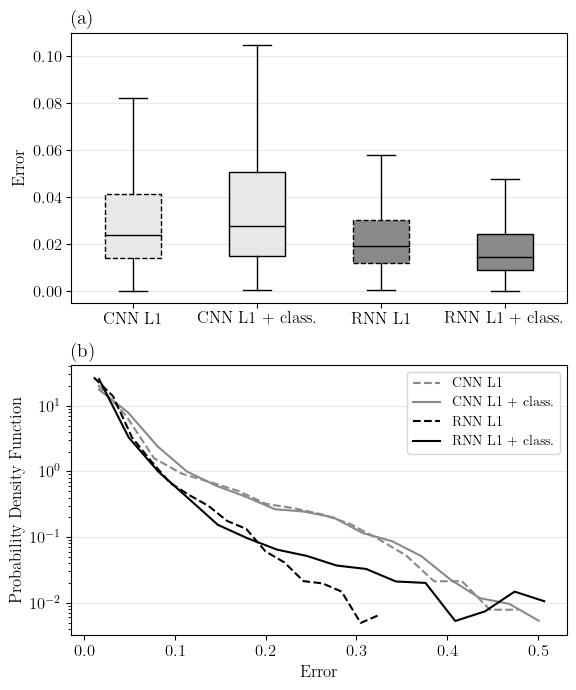

In [ ]:
################
# box plot
################
fig, axes = plt.subplots(2,1)

num_models = 4
all_errors = [error_distance_cnn_L1, error_distance_cnn_L1_class, error_distance_rnn_L1, error_distance_rnn_L1_class]

colors = np.stack([light_grey, light_grey, mid_grey, mid_grey])
linestyles = np.stack(["--","-", "--", "-"])
boxplot_obj = axes[0].boxplot(all_errors, patch_artist = True, sym = "")

# set colors for boxes
for patch, color, linestyle in zip(boxplot_obj['boxes'], colors, linestyles):
    patch.set_facecolor(color)
    patch.set_linestyle(linestyle)

for line in boxplot_obj['medians']:
    line.set_c("k")

# set labels and ticks
axes[0].set_ylabel("Error", fontsize = 12)
axes[0].tick_params(axis='both', which='major', labelsize = 12)
axes[0].tick_params(axis='both', which='minor', labelsize = 12)
axes[0].set_xticklabels(name_of_models)

axes[0].grid(axis="y", color = light_grey)
axes[0].set_title("(a)", loc = "left", fontsize = 14)

################
# PDF
################
num_bins = 16

n1, x1 = np.histogram(error_distance_cnn_L1, bins = num_bins, density = True)
n2, x2 = np.histogram(error_distance_cnn_L1_class, bins = num_bins, density = True)
n3, x3 = np.histogram(error_distance_rnn_L1, bins = num_bins, density = True)
n4, x4 = np.histogram(error_distance_rnn_L1_class, bins = num_bins, density = True)

bar_width_1 = (x1[1] - x1[0]) / 2
bar_width_2 = (x2[1] - x2[0]) / 2
bar_width_3 = (x3[1] - x3[0]) / 2
bar_width_4 = (x4[1] - x4[0]) / 2

axes[1].plot(x1[:-1] + bar_width_1, n1, color = mid_grey, label = "CNN L1", linestyle = "--")
axes[1].plot(x2[:-1] + bar_width_2, n2, color = mid_grey, label = "CNN L1 + class.", linestyle = "-")
axes[1].plot(x3[:-1] + bar_width_3, n3, color = "k", label = "RNN L1", linestyle = "--")
axes[1].plot(x4[:-1] + bar_width_4, n4, color = "k", label = "RNN L1 + class.", linestyle = "-")

axes[1].set_yscale("log")
axes[1].legend( fontsize = 10)

axes[1].set_xlabel("Error",  fontsize = 12)
axes[1].set_ylabel("Probability Density Function",  fontsize = 12)
axes[1].tick_params(axis='both', which='major', labelsize = 12)
axes[1].tick_params(axis='both', which='minor', labelsize = 12)

axes[1].grid(axis="y", color = light_grey)
axes[1].set_title("(b)", loc = "left", fontsize = 14)

fig.set_size_inches(5.9, 7)
plt.tight_layout()
#plt.savefig("./errors_and_pdf.pdf")
plt.show()

Plot errors with the model that always predicts in the centre included 

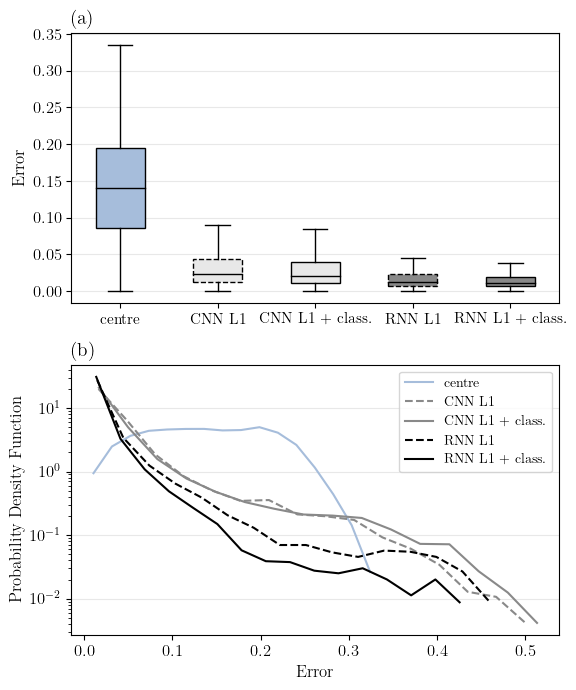

In [ ]:
################
# box plot
################
fig, axes = plt.subplots(2,1)

num_models = 5
all_errors = [error_distance_random_predicton, error_distance_cnn_L1, error_distance_cnn_L1_class, error_distance_rnn_L1, error_distance_rnn_L1_class]

x_labels = ["centre", "CNN L1", "CNN L1 + class.", "RNN L1", "RNN L1 + class."]
colors = np.stack([light_blue, light_grey, light_grey, mid_grey, mid_grey])
linestyles = np.stack(["-", "--","-", "--", "-"])
boxplot_obj = axes[0].boxplot(all_errors, patch_artist = True, sym = "")

# set colors for boxes
for patch, color, linestyle in zip(boxplot_obj['boxes'], colors, linestyles):
    patch.set_facecolor(color)
    patch.set_linestyle(linestyle)
    
for line in boxplot_obj['medians']:
    line.set_c("k")

# set labels and ticks
axes[0].set_ylabel("Error", fontsize = 12)
axes[0].tick_params(axis='both', which='major', labelsize = 12)
axes[0].tick_params(axis='both', which='minor', labelsize = 12)

axes[0].set_xticklabels(x_labels, fontsize = 11)

axes[0].grid(axis="y", color = light_grey)
axes[0].set_title("(a)", loc = "left", fontsize = 14)

################
# PDF
################
num_bins = 16

n1, x1 = np.histogram(error_distance_cnn_L1, bins = num_bins, density = True)
n2, x2 = np.histogram(error_distance_cnn_L1_class, bins = num_bins, density = True)
n3, x3 = np.histogram(error_distance_rnn_L1, bins = num_bins, density = True)
n4, x4 = np.histogram(error_distance_rnn_L1_class, bins = num_bins, density = True)
n5, x5 = np.histogram(error_distance_random_predicton, bins = num_bins, density = True)

bar_width_1 = (x1[1] - x1[0]) / 2
bar_width_2 = (x2[1] - x2[0]) / 2
bar_width_3 = (x3[1] - x3[0]) / 2
bar_width_4 = (x4[1] - x4[0]) / 2
bar_width_5 = (x5[1] - x5[0]) / 2

axes[1].plot(x5[:-1] + bar_width_5, n5, color = light_blue, label = "centre", linestyle = "-")
axes[1].plot(x1[:-1] + bar_width_1, n1, color = mid_grey, label = "CNN L1", linestyle = "--")
axes[1].plot(x2[:-1] + bar_width_2, n2, color = mid_grey, label = "CNN L1 + class.", linestyle = "-")
axes[1].plot(x3[:-1] + bar_width_3, n3, color = "k", label = "RNN L1", linestyle = "--")
axes[1].plot(x4[:-1] + bar_width_4, n4, color = "k", label = "RNN L1 + class.", linestyle = "-")

axes[1].set_yscale("log")
axes[1].legend( fontsize = 10)

axes[1].set_xlabel("Error",  fontsize = 12)
axes[1].set_ylabel("Probability Density Function",  fontsize = 12)
axes[1].tick_params(axis='both', which='major', labelsize = 12)
axes[1].tick_params(axis='both', which='minor', labelsize = 12)

axes[1].grid(axis="y", color = light_grey)
axes[1].set_title("(b)", loc = "left", fontsize = 14)

fig.set_size_inches(5.9, 7)
plt.tight_layout()
#plt.savefig("./errors_and_pdf_with_random.pdf")
plt.show()

Perform t test on the distrubutions of errors

In [62]:
from scipy import stats

a = error_distance_cnn_L1
b = error_distance_rnn_L1

# rank the data of probabilities
combined = np.concatenate((a, b))
ranks = stats.rankdata(combined)

# Split ranked data back
ranks_a = ranks[:len(a)]
ranks_b = ranks[len(a):]

t_stat, p_val = stats.ttest_ind(ranks_a, ranks_b, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, p-value: {p_val}")

T-statistic: 34.352, p-value: 5.0243999488802803e-256


Where in the image is the error largest?

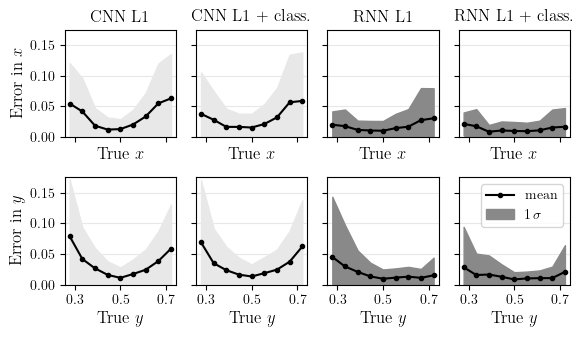

In [ ]:
fig, axes = plt.subplots(2,4, sharex="col", sharey="row")
num_bins = 10
bins_positions  = np.linspace(min(true_positions[0,:]), max(true_positions[0,:]), num = num_bins)
bins_positions_center = bins_positions[:-1] + (bins_positions[1] - bins_positions[0]) / 2
grey_color = light_grey

for i in range(2):

    # cnn L1
    means, _, _ = binned_statistic(x = true_positions[i,:], values = np.abs(error_cnn_L1[i,:]), statistic = "mean", bins = bins_positions)
    stds, _, _ = binned_statistic(x = true_positions[i,:], values = np.abs(error_cnn_L1[i,:]), statistic = "std", bins = bins_positions)
    axes[i,0].plot(bins_positions_center, means, marker = ".", color = "k")
    axes[i,0].fill_between(bins_positions_center, y1 = means + stds, y2 = means - stds, color = grey_color)

    # cnn L1 + class
    means, _, _ = binned_statistic(x = true_positions[i,:], values = np.abs(error_cnn_L1_class[i,:]), statistic = "mean", bins = bins_positions)
    stds, _, _ = binned_statistic(x = true_positions[i,:], values = np.abs(error_cnn_L1_class[i,:]), statistic = "std", bins = bins_positions)
    axes[i,1].plot(bins_positions_center, means, marker = ".", color = "k")
    axes[i,1].fill_between(bins_positions_center, y1 = means + stds, y2 = means - stds, color = grey_color)

    # rnn L1
    means, _, _ = binned_statistic(x = true_positions[i,:], values = np.abs(error_rnn_L1[i,:]), statistic = "mean", bins = bins_positions)
    stds, _, _ = binned_statistic(x = true_positions[i,:], values = np.abs(error_rnn_L1[i,:]), statistic = "std", bins = bins_positions)
    axes[i,2].plot(bins_positions_center, means, marker = ".", color = "k")
    axes[i,2].fill_between(bins_positions_center, y1 = means + stds, y2 = means - stds, color = mid_grey)

    # rnn L1 + class
    means, _, _ = binned_statistic(x = true_positions[i,:], values = np.abs(error_rnn_L1_class[i,:]), statistic = "mean", bins = bins_positions)
    stds, _, _ = binned_statistic(x = true_positions[i,:], values = np.abs(error_rnn_L1_class[i,:]), statistic = "std", bins = bins_positions)
    axes[i,3].plot(bins_positions_center, means, marker = ".", color = "k", label = "mean")
    axes[i,3].fill_between(bins_positions_center, y1 = means + stds, y2 = means - stds, color = mid_grey, label = "$1\,\sigma$")

# set limits 
for i in range(2):
    for j in range(4):
        axes[i,j].set_ylim([0,0.175])

axes[0,0].set_yticks([0,0.05,0.1,0.15])
axes[1,0].set_yticks([0,0.05,0.1,0.15])

# set fontsize
for i in range(2):
    for j in range(4):
        axes[i,j].tick_params(axis='both', which='major', labelsize = 10)
        axes[i,j].tick_params(axis='both', which='minor', labelsize = 10)
        axes[i,j].grid(axis="y", color = light_grey)
        axes[i,j].set_axisbelow(True)

# set titles and labels
for i in range(4):
    axes[1,i].set_xticks([0.3,0.5,0.7])
    axes[0,i].set_xlabel("True $x$", fontsize = 12)
    axes[1,i].set_xlabel("True $y$", fontsize = 12)
    axes[0,i].set_title(name_of_models[i], fontsize = 12)

axes[0,0].set_ylabel("Error in $x$", fontsize = 12)
axes[1,0].set_ylabel("Error in $y$", fontsize = 12)

axes[1,3].legend(fontsize = 10)

fig.set_size_inches(5.9, 5.9/1.7)
plt.tight_layout()
#plt.savefig("./true_vs_error_binned_statistic.pdf")
plt.show()

## Analysis of overlapping bacteria

In [ ]:
IMAGE_SIZE = 128

if models_analysed == "z0":
    dataset_test_collisions = torch.load('./Data/compare_collisions_seqlen65_datasetlen500_1add_z0.pt')
elif models_analysed == "zvar":
    dataset_test_collisions = torch.load('./Data/compare_collisions_seqlen65_datasetlen500_1add_zvar.pt')

dataLoader_test_collisions = DataLoader(dataset = dataset_test_collisions, batch_size = 1, shuffle = False)
dataloader_iter = iter(dataLoader_test_collisions)

Snapshots of a sequence and the predictions

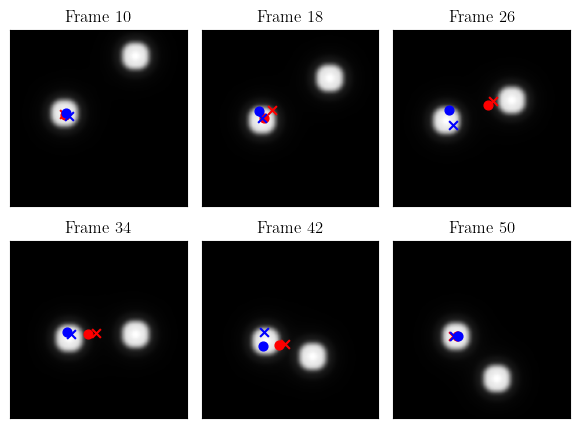

In [ ]:
images, _ = next(dataloader_iter)
n_in_sequence = len(images)
image_indices_to_store = np.linspace(10, 50, 6)
marker_size = 40
font_size = 12

# store memory for rnn
store_memory_rnn(rnn_L1, images, num_frames_to_store=10)
store_memory_rnn(rnn_L1_class, images, num_frames_to_store=10)

# make predictions
output_cnn_L1 = make_prediction_cnn(cnn_L1, images[10])
output_cnn_class = make_prediction_cnn(cnn_L1_class, images[10])
output_rnn_L1 = make_prediction_rnn(rnn_L1, images[10])
output_rnn_class = make_prediction_rnn(rnn_L1_class, images[10])

# initialize plot for a few images of the sequence
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, sharex="col", sharey="row")

axes[0,0].imshow(images[10].numpy()[0,0,:,:].T, cmap = "gray", origin = "lower")
axes[0,0].scatter(output_cnn_L1[0]*IMAGE_SIZE, output_cnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "r", label = "CNN L1 loss")
axes[0,0].scatter(output_cnn_class[0]*IMAGE_SIZE, output_cnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "r", label = "CNN L1 + class. loss")
axes[0,0].scatter(output_rnn_L1[0]*IMAGE_SIZE, output_rnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "b", label = "RNN L1 loss")
axes[0,0].scatter(output_rnn_class[0]*IMAGE_SIZE, output_rnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "b", label = "RNN L1 + class. loss")
axes[0,0].set_title(f"Frame ${10}$", fontsize = font_size)

axes[0,0].set_xticks([])
axes[0,0].set_yticks([])

image_index = 1

for i in range(11, int(max(image_indices_to_store)) + 1):

    # make predictions
    output_cnn_L1 = make_prediction_cnn(cnn_L1, images[i])
    output_cnn_class = make_prediction_cnn(cnn_L1_class, images[i])
    output_rnn_L1 = make_prediction_rnn(rnn_L1, images[i])
    output_rnn_class = make_prediction_rnn(rnn_L1_class, images[i])

    if i in image_indices_to_store:
        
        row = int(np.floor(image_index / n_cols))
        col = image_index % n_cols

        axes[row, col].imshow(images[i].numpy()[0,0,:,:].T, cmap = "gray", origin = "lower")
        axes[row, col].scatter(output_cnn_L1[0]*IMAGE_SIZE, output_cnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "r", label = "CNN L1 loss")
        axes[row, col].scatter(output_cnn_class[0]*IMAGE_SIZE, output_cnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "r", label = "CNN L1 + class. loss")
        axes[row, col].scatter(output_rnn_L1[0]*IMAGE_SIZE, output_rnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "b", label = "RNN L1 loss")
        axes[row, col].scatter(output_rnn_class[0]*IMAGE_SIZE, output_rnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "b", label = "RNN L1 + class. loss")
        axes[row, col].set_title(f"Frame $ {i} $", fontsize = font_size)
        
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

        image_index += 1

# used to generate a legend to construct figure in Inkscape
"""
axes[0,2].axis("off")
axes[0,2].scatter(output_cnn_L1[0]*IMAGE_SIZE, output_cnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "r", label = "CNN L1 loss")
axes[0,2].scatter(output_cnn_class[0]*IMAGE_SIZE, output_cnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "r", label = "CNN L1 + class. loss")
axes[0,2].scatter(output_rnn_L1[0]*IMAGE_SIZE, output_rnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "b", label = "RNN L1 loss")
axes[0,2].scatter(output_rnn_class[0]*IMAGE_SIZE, output_rnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "b", label = "RNN L1 + class. loss")

axes[0,2].scatter(output_cnn_L1[0]*IMAGE_SIZE, output_cnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "w")
axes[0,2].scatter(output_cnn_class[0]*IMAGE_SIZE, output_cnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "w")
axes[0,2].scatter(output_rnn_L1[0]*IMAGE_SIZE, output_rnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "w")
axes[0,2].scatter(output_rnn_class[0]*IMAGE_SIZE, output_rnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "w")

axes[0,2].set_xticks([])
axes[0,2].set_yticks([])
axes[0,2].legend(fontsize = 12, loc = "center left")
"""

fig.set_size_inches(5.9, 4.5)
plt.tight_layout()
#plt.savefig("./video_1_additional_bacteria.svg", format="svg", bbox_inches="tight")
plt.show()

Show video of the sequence and the predictions

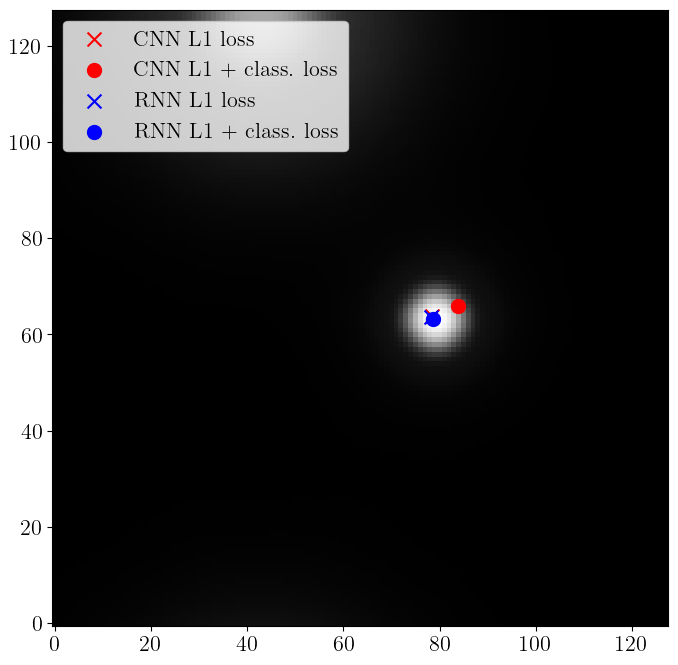

In [ ]:
from IPython.display import display, clear_output

IMAGE_SIZE = 128

images, _ = next(dataloader_iter)
n_in_sequence = len(images)

# store memory for rnn
store_memory_rnn(rnn_L1, images, num_frames_to_store=10)
store_memory_rnn(rnn_L1_class, images, num_frames_to_store=10)

# make predictions
output_cnn_L1 = make_prediction_cnn(cnn_L1, images[10])
output_cnn_class = make_prediction_cnn(cnn_L1_class, images[10])
output_rnn_L1 = make_prediction_rnn(rnn_L1, images[10])
output_rnn_class = make_prediction_rnn(rnn_L1_class, images[10])

# initialize plot for updated video
fig, ax = plt.subplots(1,1)

image_plot = ax.imshow(images[10].numpy()[0,0,:,:].T, cmap = "gray", origin = "lower")
marker_size = 100
position_plot_cnn_L1 = ax.scatter(output_cnn_L1[0]*IMAGE_SIZE, output_cnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "r", label = "CNN L1 loss")
position_plot_cnn_class = ax.scatter(output_cnn_class[0]*IMAGE_SIZE, output_cnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "r", label = "CNN L1 + class. loss")

position_plot_rnn_L1 = ax.scatter(output_rnn_L1[0]*IMAGE_SIZE, output_rnn_L1[1]*IMAGE_SIZE, marker = "x", s = marker_size, color = "b", label = "RNN L1 loss")
position_plot_rnn_class = ax.scatter(output_rnn_class[0]*IMAGE_SIZE, output_rnn_class[1]*IMAGE_SIZE, marker = "o", s = marker_size, color = "b", label = "RNN L1 + class. loss")

font_size = 16

ax.legend(fontsize = font_size, loc = "upper left")
ax.tick_params(axis='both', which='major', labelsize = font_size)
ax.tick_params(axis='both', which='minor', labelsize = font_size)
fig.set_size_inches(8, 8)

plt.show()

for i in range(10, n_in_sequence):

    # make predictions
    output_cnn_L1 = make_prediction_cnn(cnn_L1, images[i])
    output_cnn_class = make_prediction_cnn(cnn_L1_class, images[i])

    output_rnn_L1 = make_prediction_rnn(rnn_L1, images[i])
    output_rnn_class = make_prediction_rnn(rnn_L1_class, images[i])

    # update data
    image_plot.set_data(images[i].numpy()[0,0,:,:].T)

    position_plot_cnn_L1.set_offsets([output_cnn_L1[0] * IMAGE_SIZE, output_cnn_L1[1] * IMAGE_SIZE])
    position_plot_cnn_class.set_offsets([output_cnn_class[0] * IMAGE_SIZE, output_cnn_class[1] * IMAGE_SIZE])
    position_plot_rnn_L1.set_offsets([output_rnn_L1[0] * IMAGE_SIZE, output_rnn_L1[1] * IMAGE_SIZE])
    position_plot_rnn_class.set_offsets([output_rnn_class[0] * IMAGE_SIZE, output_rnn_class[1] * IMAGE_SIZE])
   
    clear_output(wait=True)
    display(fig)

plt.show()
plt.close(fig)


Define functions used in computations below

In [7]:
def is_prediction_closer_to_correct_particle(position_want_to_track, additional_positions, position_predicted):

    distance_predicted_to_correct_particle = np.linalg.norm(position_want_to_track - position_predicted)

    min_distance_predicted_to_add_particle = np.linalg.norm(additional_positions[0][0:2] - position_predicted)

    for i in range(1, len(additional_positions)):
           distance = np.linalg.norm(additional_positions[i][0:2] - position_predicted)
           if distance < min_distance_predicted_to_add_particle:
                min_distance_predicted_to_add_particle = distance
    
    if distance_predicted_to_correct_particle < min_distance_predicted_to_add_particle:
        return 1
    else:
        return 0
    
def compute_distances_to_true_position(prediction, true_position, additional_positions):

    num_particles_total = 1 + len(additional_positions)
    distances = torch.zeros(num_particles_total)

    # distance to true position
    distances[0] = (prediction - torch.tensor(true_position)).pow(2).sum().sqrt()

    # distances to additional positions
    for i in range(1, num_particles_total):
        additional_position = additional_positions[i-1][0:2] # change to 0:3 to z prediction
        distances[i] = (prediction - torch.tensor(additional_position)).pow(2).sum().sqrt()

    return distances


Count frames where prediciton is closest to true position

In [ ]:
dataLoader_used_in_collision_test = dataLoader_test_collisions
test_set_length = 500
images_per_sequence = 65
images_per_sequence_used_for_prediction = images_per_sequence - 20
num_images_not_used_in_end_of_sequence = 10 # do not use images at the start and end bc little risk of overlap

# initialize storage for results
closest_particle_cnn_L1 = np.zeros(test_set_length * images_per_sequence_used_for_prediction)
closest_particle_cnn_L1_class = np.zeros(test_set_length * images_per_sequence_used_for_prediction)
closest_particle_rnn_end_to_end_L1 = np.zeros(test_set_length * images_per_sequence_used_for_prediction)
closest_particle_rnn_end_to_end_L1_class = np.zeros(test_set_length * images_per_sequence_used_for_prediction)
closest_particle_random =  np.zeros(test_set_length * images_per_sequence_used_for_prediction)

for i, data in enumerate(dataLoader_used_in_collision_test):
    images, positions = data
    
    # for rnn end to end
    store_memory_rnn(rnn_L1, images, 10)
    store_memory_rnn(rnn_L1_class, images, 10)

    for j in range(10, images_per_sequence - num_images_not_used_in_end_of_sequence):

        # compute positions
        positions_at_time_step = positions[j].numpy()[0]
        index_true_position = np.where(positions_at_time_step[:,3] == 1)[0][0]
        true_position = positions_at_time_step[index_true_position, 0:2] # change to 0:3 for z prediction
        additional_positions = np.delete(positions_at_time_step, index_true_position, axis = 0)

        # cnn L1
        output = make_prediction_cnn(cnn_L1, images[j])
        closest_particle_cnn_L1[i*images_per_sequence_used_for_prediction + (j-10)] = is_prediction_closer_to_correct_particle(true_position, additional_positions, output)

        # cnn L1 + class
        output = make_prediction_cnn(cnn_L1_class, images[j])
        closest_particle_cnn_L1_class[i*images_per_sequence_used_for_prediction + (j-10)] = is_prediction_closer_to_correct_particle(true_position, additional_positions, output)

        # rnn L1 
        output = make_prediction_rnn(rnn_L1, images[j])
        closest_particle_rnn_end_to_end_L1[i*images_per_sequence_used_for_prediction + (j-10)] = is_prediction_closer_to_correct_particle(true_position, additional_positions, output)

        # rnn L1 + class
        output = make_prediction_rnn(rnn_L1_class, images[j])
        closest_particle_rnn_end_to_end_L1_class[i*images_per_sequence_used_for_prediction + (j-10)] = is_prediction_closer_to_correct_particle(true_position, additional_positions, output)

        # random prediction (in the centre of the image)
        closest_particle_random[i*images_per_sequence_used_for_prediction + (j-10)] = is_prediction_closer_to_correct_particle(true_position, additional_positions, [0.5,0.5])


Plot fractions of frames where the prediction is closer to the additional bacteria

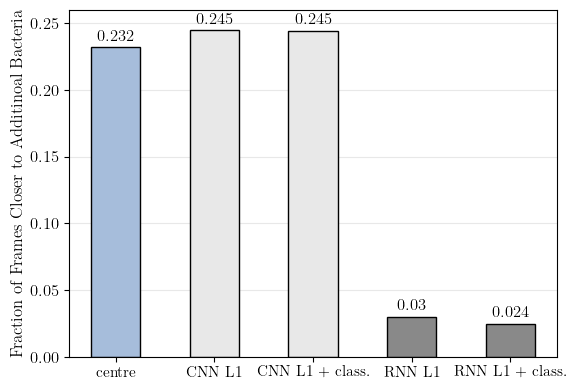

In [ ]:
num_frames_total = len(closest_particle_cnn_L1)
number_of_frames_closest_to_correct = np.array([np.count_nonzero(closest_particle_random), np.count_nonzero(closest_particle_cnn_L1), np.count_nonzero(closest_particle_cnn_L1_class),  np.count_nonzero(closest_particle_rnn_end_to_end_L1), np.count_nonzero(closest_particle_rnn_end_to_end_L1_class)]) / num_frames_total
number_of_frames_closest_to_wrong = np.array([np.count_nonzero(closest_particle_random == 0), np.count_nonzero(closest_particle_cnn_L1==0), np.count_nonzero(closest_particle_cnn_L1_class==0), np.count_nonzero(closest_particle_rnn_end_to_end_L1==0), np.count_nonzero(closest_particle_rnn_end_to_end_L1_class == 0)]) / num_frames_total

x_positions = np.arange(1,6)
steel_blue = np.array([70, 130, 180]) / 255
light_blue = np.array([166, 189,219]) / 255

# plot only the incorrect fractions
fig, ax = plt.subplots(1,1)
bar_width = 0.5
ax.bar(x_positions, number_of_frames_closest_to_wrong, bar_width, color = [light_blue, light_grey, light_grey, mid_grey, mid_grey], edgecolor = "k")

for i in range(len(x_positions)):
    ax.text(i+1, number_of_frames_closest_to_wrong[i]+0.005, float(f"{number_of_frames_closest_to_wrong[i]:.3f}"), ha='center', fontsize =12) #, bbox=dict(facecolor="w", alpha=1))  # Aligning text at center

# plot settings
ax.tick_params(axis='both', which='major', labelsize = 12)
ax.tick_params(axis='both', which='minor', labelsize = 12)
ax.set_xticks(x_positions)

name_of_models_and_random = ["centre", "CNN L1", "CNN L1 + class.", "RNN L1", "RNN L1 + class."]
ax.set_xticklabels(name_of_models_and_random, fontsize = 11)

ax.set_ylabel("Fraction of Frames Closer to Additinoal Bacteria", fontsize = 12)
ax.grid(axis = "y", color = light_grey)
ax.set_axisbelow(True)

fig.set_size_inches(5.9, 4)
plt.tight_layout()
#plt.savefig("./overlap.pdf", format="pdf", bbox_inches="tight")
plt.show()

Compute softmin values corresponding to the centre bacteria, based on the distances from the prediction to all positions in the frame

In [ ]:
# initialize storage for results
prob_center_bacteria_cnn_L1 = np.zeros(test_set_length * images_per_sequence_used_for_prediction)
prob_center_bacteria_cnn_L1_class = np.zeros(test_set_length * images_per_sequence_used_for_prediction)
prob_center_bacteria_rnn_end_to_end_L1 = np.zeros(test_set_length * images_per_sequence_used_for_prediction)
prob_center_bacteria_rnn_end_to_end_L1_class = np.zeros(test_set_length * images_per_sequence_used_for_prediction)
prob_center_bacteria_rnn_end_to_end_L1_class = np.zeros(test_set_length * images_per_sequence_used_for_prediction)
prob_center_bacteria_random = np.zeros(test_set_length * images_per_sequence_used_for_prediction)

for i, data in enumerate(dataLoader_used_in_collision_test):
    images, positions = data
    
    # for rnn end to end
    store_memory_rnn(rnn_L1, images, 10)
    store_memory_rnn(rnn_L1_class, images, 10)

    for j in range(10, images_per_sequence - num_images_not_used_in_end_of_sequence):

        # compute positions
        positions_at_time_step = positions[j].numpy()[0]
        index_true_position = np.where(positions_at_time_step[:,3] == 1)[0][0]
        true_position = positions_at_time_step[index_true_position, 0:2] # change to 0:3 for z prediction
        additional_positions = np.delete(positions_at_time_step, index_true_position, axis = 0)

        # cnn L1
        output = make_prediction_cnn(cnn_L1, images[j])
        distances = compute_distances_to_true_position(torch.tensor(output), true_position, additional_positions)
        probabilities_for_classification_of_correct_particle = nn.functional.softmin(distances, dim = 0) 
        prob_center_bacteria_cnn_L1[i*images_per_sequence_used_for_prediction + (j-10)] = probabilities_for_classification_of_correct_particle[0]

        # cnn L1 + class
        output = make_prediction_cnn(cnn_L1_class, images[j])
        distances = compute_distances_to_true_position(torch.tensor(output), true_position, additional_positions)
        probabilities_for_classification_of_correct_particle = nn.functional.softmin(distances, dim = 0) 
        prob_center_bacteria_cnn_L1_class[i*images_per_sequence_used_for_prediction + (j-10)] = probabilities_for_classification_of_correct_particle[0]

        # rnn L1 
        output = make_prediction_rnn(rnn_L1, images[j])
        distances = compute_distances_to_true_position(torch.tensor(output), true_position, additional_positions)
        probabilities_for_classification_of_correct_particle = nn.functional.softmin(distances, dim = 0) 
        prob_center_bacteria_rnn_end_to_end_L1[i*images_per_sequence_used_for_prediction + (j-10)] = probabilities_for_classification_of_correct_particle[0]

        # rnn L1 + class
        output = make_prediction_rnn(rnn_L1_class, images[j])
        distances = compute_distances_to_true_position(torch.tensor(output), true_position, additional_positions)
        probabilities_for_classification_of_correct_particle = nn.functional.softmin(distances, dim = 0) 
        prob_center_bacteria_rnn_end_to_end_L1_class[i*images_per_sequence_used_for_prediction + (j-10)] = probabilities_for_classification_of_correct_particle[0]

        # random
        output = [0.5,0.5]
        distances = compute_distances_to_true_position(torch.tensor(output), true_position, additional_positions)
        probabilities_for_classification_of_correct_particle = nn.functional.softmin(distances, dim = 0)
        prob_center_bacteria_random[i*images_per_sequence_used_for_prediction + (j-10)] = probabilities_for_classification_of_correct_particle[0]

Plot distributions of softmin values

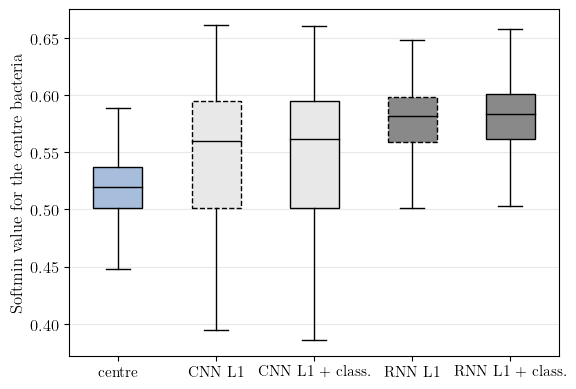

In [ ]:
fig, axes = plt.subplots(1,1)

num_models = 4
all_probabilities = [prob_center_bacteria_random, prob_center_bacteria_cnn_L1, prob_center_bacteria_cnn_L1_class, prob_center_bacteria_rnn_end_to_end_L1, prob_center_bacteria_rnn_end_to_end_L1_class]

x_labels = ["centre", "CNN L1", "CNN L1 + class.", "RNN L1", "RNN L1 + class."]
colors = np.stack([light_blue, light_grey, light_grey, mid_grey, mid_grey])
linestyles = np.stack(["-","--","-", "--", "-"])
boxplot_obj = axes.boxplot(all_probabilities, patch_artist = True, sym = "")

#set colors for boxes
for patch, color, linestyle in zip(boxplot_obj['boxes'], colors, linestyles):
    patch.set_facecolor(color)
    patch.set_linestyle(linestyle)

for line in boxplot_obj['medians']:
    line.set_c("k")

# set labels and ticks
axes.set_ylabel("", fontsize = 12)
axes.tick_params(axis='both', which='major', labelsize = 12)
axes.tick_params(axis='both', which='minor', labelsize = 12)

axes.set_ylabel("Softmin value for the centre bacteria", fontsize = 12)
axes.set_xticklabels(x_labels, fontsize = 11)
axes.grid(axis="y", color = light_grey)

fig.set_size_inches(5.9, 4)
plt.tight_layout()
#plt.savefig("./overlap_distributions.pdf", format="pdf", bbox_inches="tight")
plt.show()


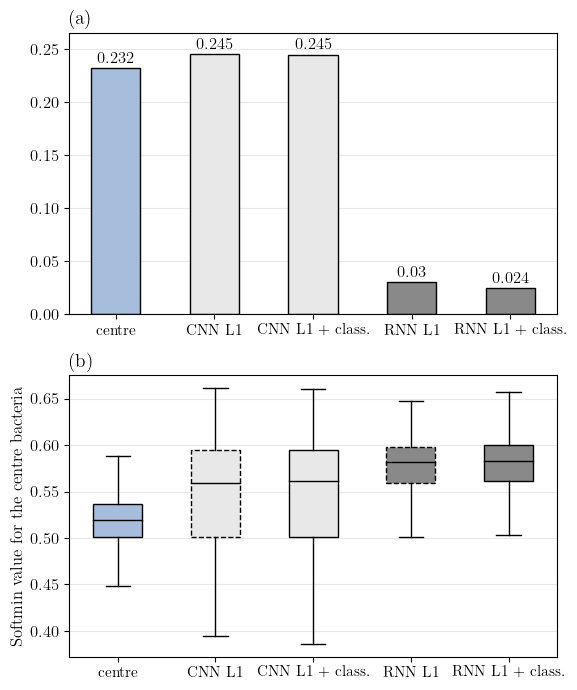

In [ ]:
fig, axes = plt.subplots(2,1)

num_frames_total = len(closest_particle_cnn_L1)
number_of_frames_closest_to_correct = np.array([np.count_nonzero(closest_particle_random), np.count_nonzero(closest_particle_cnn_L1), np.count_nonzero(closest_particle_cnn_L1_class),  np.count_nonzero(closest_particle_rnn_end_to_end_L1), np.count_nonzero(closest_particle_rnn_end_to_end_L1_class)]) / num_frames_total
number_of_frames_closest_to_wrong = np.array([np.count_nonzero(closest_particle_random == 0), np.count_nonzero(closest_particle_cnn_L1==0), np.count_nonzero(closest_particle_cnn_L1_class==0), np.count_nonzero(closest_particle_rnn_end_to_end_L1==0), np.count_nonzero(closest_particle_rnn_end_to_end_L1_class == 0)]) / num_frames_total

x_positions = np.arange(1,6)
steel_blue = np.array([70, 130, 180]) / 255
light_blue = np.array([166, 189,219]) / 255

# plot only the incorrect fractions
bar_width = 0.5
axes[0].bar(x_positions, number_of_frames_closest_to_wrong, bar_width, color = [light_blue, light_grey, light_grey, mid_grey, mid_grey], edgecolor = "k")

for i in range(len(x_positions)):
    axes[0].text(i+1, number_of_frames_closest_to_wrong[i]+0.005, float(f"{number_of_frames_closest_to_wrong[i]:.3f}"), ha='center', fontsize =12) #, bbox=dict(facecolor="w", alpha=1))  # Aligning text at center

# plot settings
axes[0].tick_params(axis='both', which='major', labelsize = 12)
axes[0].tick_params(axis='both', which='minor', labelsize = 12)
axes[0].set_xticks(x_positions)

name_of_models_and_random = ["centre", "CNN L1", "CNN L1 + class.", "RNN L1", "RNN L1 + class."]
axes[0].set_xticklabels(name_of_models_and_random, fontsize = 11)
ax.set_ylabel("Fraction of Frames Closer to Additinoal Bacteria", fontsize = 12)

axes[0].grid(axis = "y", color = light_grey)
axes[0].set_axisbelow(True)
axes[0].set_title("(a)", loc = "left", fontsize = 14)

########################################
# deeper analysis
########################################

num_models = 4
all_probabilities = [prob_center_bacteria_random, prob_center_bacteria_cnn_L1, prob_center_bacteria_cnn_L1_class, prob_center_bacteria_rnn_end_to_end_L1, prob_center_bacteria_rnn_end_to_end_L1_class]

x_labels = ["centre", "CNN L1", "CNN L1 + class.", "RNN L1", "RNN L1 + class."]
colors = np.stack([light_blue, light_grey, light_grey, mid_grey, mid_grey])
linestyles = np.stack(["-","--","-", "--", "-"])
boxplot_obj = axes[1].boxplot(all_probabilities, patch_artist = True, sym = "")


#set colors for boxes
for patch, color, linestyle in zip(boxplot_obj['boxes'], colors, linestyles):
    patch.set_facecolor(color)
    patch.set_linestyle(linestyle)

for line in boxplot_obj['medians']:
    line.set_c("k")

# set labels and ticks
axes[1].set_ylabel("", fontsize = 12)
axes[1].tick_params(axis='both', which='major', labelsize = 12)
axes[1].tick_params(axis='both', which='minor', labelsize = 12)

axes[1].set_ylabel("Softmin value for the centre bacteria", fontsize = 12)
axes[1].set_xticklabels(x_labels, fontsize = 11)
axes[1].grid(axis="y", color = light_grey)
axes[1].set_title("(b)", loc = "left", fontsize = 14)

fig.set_size_inches(5.9, 7)
plt.tight_layout()
#plt.savefig("./overlap_combined.pdf")
plt.show()

Perform t test on the distrubutions of softmin values

In [86]:
from scipy.stats import rankdata

a = prob_center_bacteria_rnn_end_to_end_L1
b = prob_center_bacteria_rnn_end_to_end_L1_class

# rank the data of probabilities
combined = np.concatenate((a, b))
ranks = rankdata(combined)

# Split ranked data back
ranks_a = ranks[:len(a)]
ranks_b = ranks[len(a):]

t_stat, p_val = stats.ttest_ind(ranks_a, ranks_b, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, p-value: {p_val}")

T-statistic: -7.180, p-value: 7.09169152893672e-13


## Test importance of features of bacteria for prediction

In [ ]:
# load model
rnn_two_losses_zvar = RNN()
rnn_two_losses_zvar.load_state_dict(torch.load("./rnn_class_zvar.pt", weights_only=True))
rnn_two_losses_zvar.eval()

recurrent_nn_3LSTM(
  (ReLU): ReLU()
  (leakyReLU): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
  (batch_norm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(16, 16, kern

Compute which bacteria is closest to the prediction for each dataset with varying parameters 

In [ ]:
num_datasets = 11
z_add_values = np.linspace(10,90,11, dtype=int)
print(z_add_values)

images_per_sequence = 65
num_images_not_used_in_end_of_sequence = 10
images_per_sequence_used_for_prediction = images_per_sequence - 20
test_set_length = 500

predictions = np.zeros((num_datasets, 2, test_set_length * images_per_sequence_used_for_prediction))
error = np.zeros((num_datasets, 2, test_set_length * images_per_sequence_used_for_prediction))
closest_particle = np.zeros((num_datasets, test_set_length * images_per_sequence_used_for_prediction))
true_positions = np.zeros((num_datasets, 2, test_set_length * images_per_sequence_used_for_prediction))

for k in range(num_datasets):

    # load data
    print(f"loading dataset {k+1}")
    dataset_name = f"./feature_tests/intensity/feature_imp_z0_z{z_add_values[k]}_1add_len500_seqlen_65.pt" # change based on the url of your datasets
    dataset = torch.load(dataset_name)  
    dataLoader_test_feature = DataLoader(dataset = dataset, batch_size = 1, shuffle = False)

    for i, data in enumerate(dataLoader_test_feature):

        images, positions = data
        seqlen = len(images)

        store_memory_rnn(rnn_two_losses_zvar, images, 10)

        for j in range(10, images_per_sequence - num_images_not_used_in_end_of_sequence):
            
            # compute positions
            positions_at_time_step = positions[j].numpy()[0]
            index_true_position = np.where(positions_at_time_step[:,3] == 1)[0][0]
            true_position = positions_at_time_step[index_true_position, 0:2] # change to 0:3 for z prediction
            additional_positions = np.delete(positions_at_time_step, index_true_position, axis = 0)

            true_positions[k,:, i*images_per_sequence_used_for_prediction + (j-10)] = true_position            
            closest_particle[k, i*images_per_sequence_used_for_prediction + (j-10)] = is_prediction_closer_to_correct_particle(true_position, additional_positions, [0.5,0.5])

#np.savetxt('./feature_tests/z/closest_particle_z0_z0.txt', closest_particle, fmt='%f')

[10 18 26 34 42 50 58 66 74 82 90]
loading dataset 1
loading dataset 2
loading dataset 3
loading dataset 4
loading dataset 5
loading dataset 6
loading dataset 7
loading dataset 8
loading dataset 9
loading dataset 10
loading dataset 11


Plot result of feature analysis after the computation above has been carried out for all datasets

[0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]


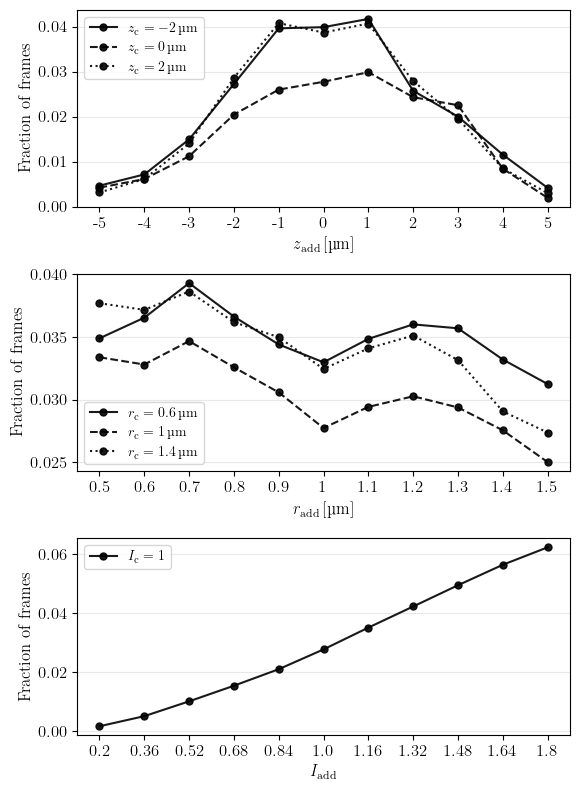

In [ ]:
from matplotlib.ticker import FormatStrFormatter

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{siunitx}')

# plot data
fig, axes = plt.subplots(3,1)

#########################
# varying z
#########################

closest_particle_low = np.loadtxt('./feature_tests/z/closest_particle_z-20.txt')
closest_particle_mid = np.loadtxt('./feature_tests/z/closest_particle_z0.txt')
closest_particle_high = np.loadtxt('./feature_tests/z/closest_particle_z20.txt')

closest_particle_different_data = [closest_particle_low, closest_particle_mid, closest_particle_high]
legend_names = [r"$z_{\text{c}} = \qty{-2}{\micro\meter}$", r"$z_{\text{c}} = \qty{0}{\micro\meter}$", r"$z_{\text{c}} = \qty{2}{\micro\meter}$"]
linestyles = ["-", "--", ":"]

for i in range(3):

    # compute number of frames closer incorrect particle
    num_frames_total = len(closest_particle_different_data[i][0,:])
    number_of_frames_closest_to_wrong = []
    for k in range(num_datasets):
        number_of_frames_closest_to_wrong.append(np.count_nonzero(closest_particle_different_data[i][k,:]== 0) / num_frames_total)

    # plot fractions of correct and incorrect predictions
    x_positions = np.arange(1, num_datasets + 1)
    axes[0].plot(x_positions, number_of_frames_closest_to_wrong, marker = "o", markersize = 5, color = "k", linestyle = linestyles[i], alpha = 0.9, linewidth = 1.5, label = legend_names[i])

z_add_values = np.arange(-5,6,1)
x_labels = z_add_values

# plot settings
axes[0].tick_params(axis='both', which='major', labelsize = 12)
axes[0].tick_params(axis='both', which='minor', labelsize = 12)
axes[0].set_xticks(x_positions)
axes[0].set_xticklabels(x_labels)
axes[0].set_ylabel("Fraction of frames", fontsize = 12)
axes[0].set_xlabel(r"$z_\text{add}\, [ \unit{\micro\meter}]$", fontsize = 12)
axes[0].grid(axis = "y", color = light_grey)
axes[0].legend(loc = "upper left")


#########################
# varying radius
#########################

closest_particle_low = np.loadtxt('./feature_tests/radius/closest_particle_r06.txt')
closest_particle_mid = np.loadtxt('./feature_tests/radius/closest_particle_r1.txt')
closest_particle_high = np.loadtxt('./feature_tests/radius/closest_particle_r14.txt')

closest_particle_different_data = [closest_particle_low, closest_particle_mid, closest_particle_high]
legend_names = [r"$r_{\text{c}} = \qty{0.6}{\micro\meter}$", r"$r_{\text{c}} = \qty{1}{\micro\meter}$", r"$r_{\text{c}} = \qty{1.4}{\micro\meter}$"]

for i in range(3):

    # compute number of frames closer incorrect particle
    num_frames_total = len(closest_particle_different_data[i][0,:])
    number_of_frames_closest_to_wrong = []
    for k in range(num_datasets):
        number_of_frames_closest_to_wrong.append(np.count_nonzero(closest_particle_different_data[i][k,:]== 0) / num_frames_total)

    # plot fractions of correct and incorrect predictions
    x_positions = np.arange(1, num_datasets + 1)
    axes[1].plot(x_positions, number_of_frames_closest_to_wrong, marker = "o",  markersize = 5, color = "k", linestyle = linestyles[i], alpha = 0.9, linewidth = 1.5, label = legend_names[i])

r_add_values = np.linspace(0.5, 1.5, 11)
r_add_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
x_labels = r_add_values

# plot settings
axes[1].tick_params(axis='both', which='major', labelsize = 12)
axes[1].tick_params(axis='both', which='minor', labelsize = 12)
axes[1].set_xticks(x_positions)
axes[1].set_xticklabels(x_labels)
axes[1].set_ylabel("Fraction of frames", fontsize = 12)
axes[1].set_xlabel(r"$r_\text{add} \,[ \unit{\micro\meter}]$", fontsize = 12)
axes[1].grid(axis = "y", color = light_grey)
axes[1].legend(loc = "lower left")


#########################
# varying intensity
#########################
closest_particle_mid = np.loadtxt('./feature_tests/intensity/closest_particle_i50.txt')

closest_particle_different_data = [closest_particle_mid]
legend_names = [r"$I_{\text{c}} = 18$", r"$I_{\text{c}} = 50$", r"$I_{\text{c}} = 82$"]
legend_names = [r"$I_{\text{c}} = 1$"]

for i in range(1):

    # compute number of frames closer to incorrect particle
    num_frames_total = len(closest_particle_different_data[i][0,:])
    number_of_frames_closest_to_wrong = []
    for k in range(num_datasets):
        number_of_frames_closest_to_wrong.append(np.count_nonzero(closest_particle_different_data[i][k,:]== 0) / num_frames_total)

    # plot fractions of correct and incorrect predictions
    x_positions = np.arange(1, num_datasets + 1)
    axes[2].plot(x_positions, number_of_frames_closest_to_wrong, marker = "o",  markersize = 5, color = "k", linestyle = linestyles[i], alpha = 0.9, linewidth = 1.5, label = legend_names[i])

i_add_values = np.linspace(10,90,11, dtype=int) / 50
x_labels = i_add_values

# plot settings
axes[2].tick_params(axis='both', which='major', labelsize = 12)
axes[2].tick_params(axis='both', which='minor', labelsize = 12)
axes[2].set_xticks(x_positions)
axes[2].set_xticklabels(x_labels)
axes[2].set_ylabel("Fraction of frames", fontsize = 12)
axes[2].set_xlabel(r"$I_\text{add}$", fontsize = 12)
axes[2].grid(axis = "y", color = light_grey)
axes[2].legend(loc = "upper left")


fig.set_size_inches(5.9, 8)
plt.tight_layout()
plt.savefig("./feature_importance.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Plot training processes for the models

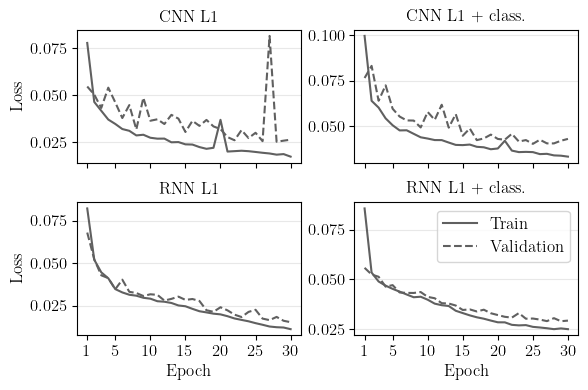

In [ ]:
n_epochs = 30
name_of_models = ["CNN L1", "CNN L1 + class.", "RNN L1", "RNN L1 + class."]

fig, axes = plt.subplots(2,2, sharex="col")
font_size = 12

# z0
#urls_train = ['./Training_logs/z0/final_logs/training_loss_epoch_CNN_L1_z0_30ep.txt', './Training_logs/z0/final_logs/training_loss_epoch_CNN_L1_class_z0_30ep.txt', './Training_logs/z0/final_logs/training_loss_epoch_RNN_L1_z0_30ep.txt', './Training_logs/z0/final_logs/training_loss_epoch_RNN_class_z0_30ep.txt']
#urls_test = ['./Training_logs/z0/final_logs/validation_loss_epoch_CNN_L1_z0_30ep.txt', './Training_logs/z0/final_logs/validation_loss_epoch_CNN_L1_class_z0_30ep.txt', './Training_logs/z0/final_logs/validation_loss_epoch_RNN_L1_z0_30ep.txt', './Training_logs/z0/final_logs/validation_loss_epoch_RNN_class_z0_30ep.txt']

# zvar
urls_train = ['training_loss_epoch_CNN_L1_zvar_30ep.txt', './Training_logs/zvar/final_logs/training_loss_epoch_CNN_L1_class_zvar.txt', './Training_logs/zvar/final_logs/training_loss_epoch_RNN_L1_zvar.txt', './Training_logs/zvar/final_logs/training_loss_epoch_RNN_L1_class_zvar.txt']
urls_test = ['validation_loss_epoch_CNN_L1_zvar_30ep.txt', './Training_logs/zvar/final_logs/validation_loss_epoch_CNN_L1_class_zvar.txt', './Training_logs/zvar/final_logs/validation_loss_epoch_RNN_L1_zvar.txt', './Training_logs/zvar/final_logs/validation_loss_epoch_RNN_L1_class_zvar.txt']

epochs = np.arange(1, 31, 1)
k = 0

for i in range(2):
    for j in range(2):
        
        training_loss_per_epoch = np.loadtxt(urls_train[k], dtype=float)
        validation_loss_per_epoch = np.loadtxt(urls_test[k], dtype=float)

        if i == 0 and j == 0:
            axes[i,j].plot(np.delete(epochs, 21), training_loss_per_epoch[0:], marker = "", label = "Train", color = dark_grey)
        else:
            axes[i,j].plot(epochs, training_loss_per_epoch[0:], marker = "", label = "Train", color = dark_grey)

        axes[i,j].plot(epochs, validation_loss_per_epoch[0:], marker = "", label = "Validation", color = dark_grey, linestyle = "--")

        axes[i,j].set_xticks([1, 5,10,15,20,25,30])
        axes[i,j].tick_params(axis='both', which='major', labelsize = 12)
        axes[i,j].tick_params(axis='both', which='minor', labelsize = 12)
        axes[i,j].grid(axis="y", color = light_grey)

        axes[i,j].set_title(name_of_models[k])

        k += 1

axes[1,1].legend(fontsize = font_size)
axes[1,0].set_xlabel("Epoch", fontsize = font_size)
axes[1,1].set_xlabel("Epoch", fontsize = font_size)
axes[0,0].set_ylabel("Loss", fontsize = font_size)
axes[1,0].set_ylabel("Loss", fontsize = font_size)

fig.set_size_inches(5.9, 4)
plt.tight_layout()
#plt.savefig("./training_process.pdf")
plt.show()